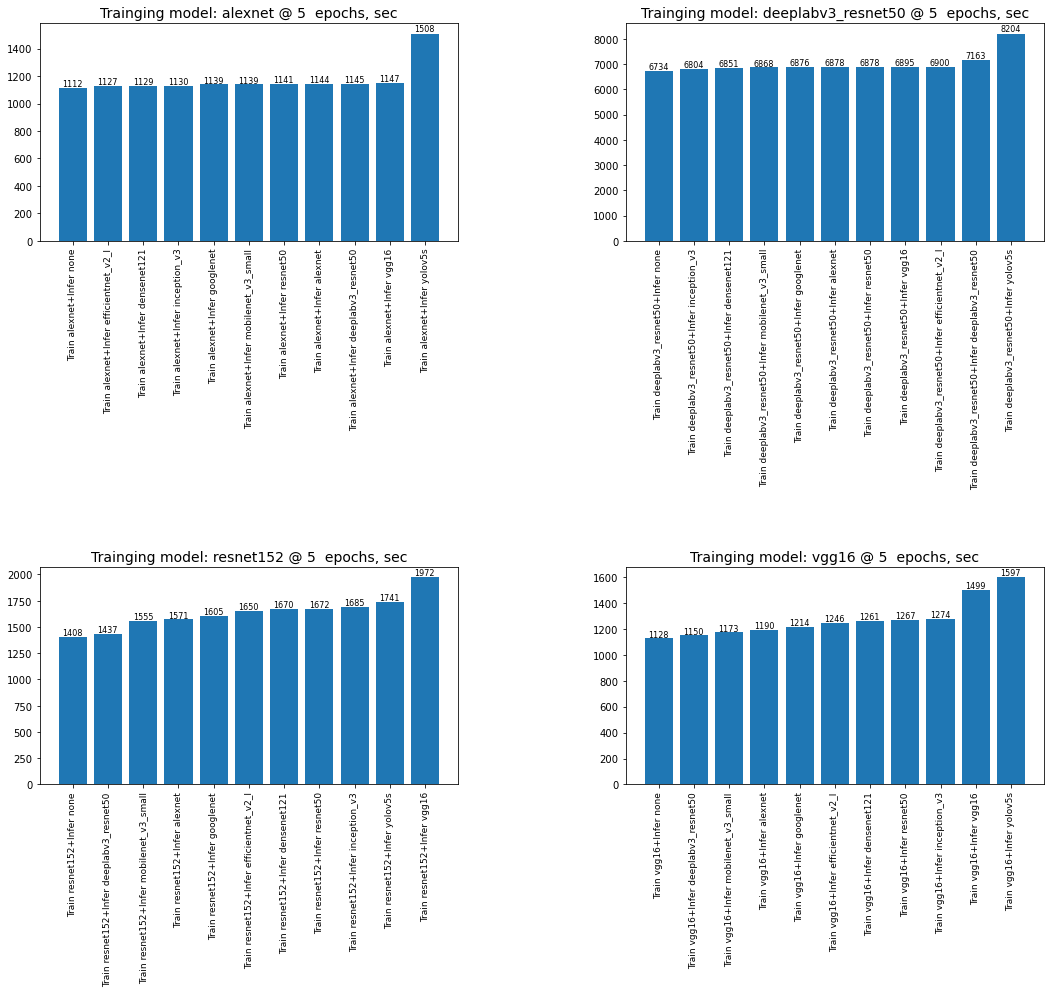

In [36]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np

file = '../result/log/profiler_log_20230211000401.csv'

df = pd.read_csv(file)
train_models = np.unique(df['train_configure'])

def str2model_name(string):# extra 'alexnet' from string of {'arch': 'alexnet', 'workers': 1, 'epochs': 5, 'batch_size': 1024, 'image_size': 224, 'device': 'cuda'}
    string = re.findall(r'{(.+)}', string)[0]
    arch_dict= string.split(',')[0]  # get 'arch': 'none' , 'arch': 'yolov5s', ...
    model_name = arch_dict.split(':')[1] 
    model_name = re.findall(r'\'(.+)\'',model_name)[0]  ## extract str from 'str', e.g. yolov5s from 'yolov5s'
    return model_name

plot=plt.figure(figsize=(18,14))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.4,hspace=1.5)

for j, train_model in enumerate(train_models):
    train_model_name = str2model_name(train_model)
    data = df.where(df['train_configure']== train_model).dropna()
    task_name_list = []
    dur_list = []
    plt.subplot(2,2,j+1) # e.g 
    for conf in data['infer_configure']:        
        infer_model_name = str2model_name(conf)
        task_name = 'Train '+train_model_name+ '+' +'Infer '+ infer_model_name
        task_name_list.append(task_name)
    for dur_str in data['result']:
        dur = re.findall(r'([0-9]+.[0-9]+)',dur_str)[0] # string
        dur=float(dur) #float
        dur_list.append(dur)
    x = range(len(dur_list))
    data_frame = pd.DataFrame({'task':task_name_list, 'dur':dur_list})
    data_frame = data_frame.sort_values('dur')
    plt.xticks(fontsize= 9, rotation = 90)  #set label size
    plt.title('Trainging model: '+train_model_name+' @ 5  epochs, sec', fontsize= 14)
    plt.bar(data_frame['task'],data_frame['dur'])
    dur_list=data_frame['dur'].tolist()
    for i in range(len(dur_list)):
        plt.text(i-0.3, dur_list[i]*1.01, int(dur_list[i]), fontsize =8)
    

    


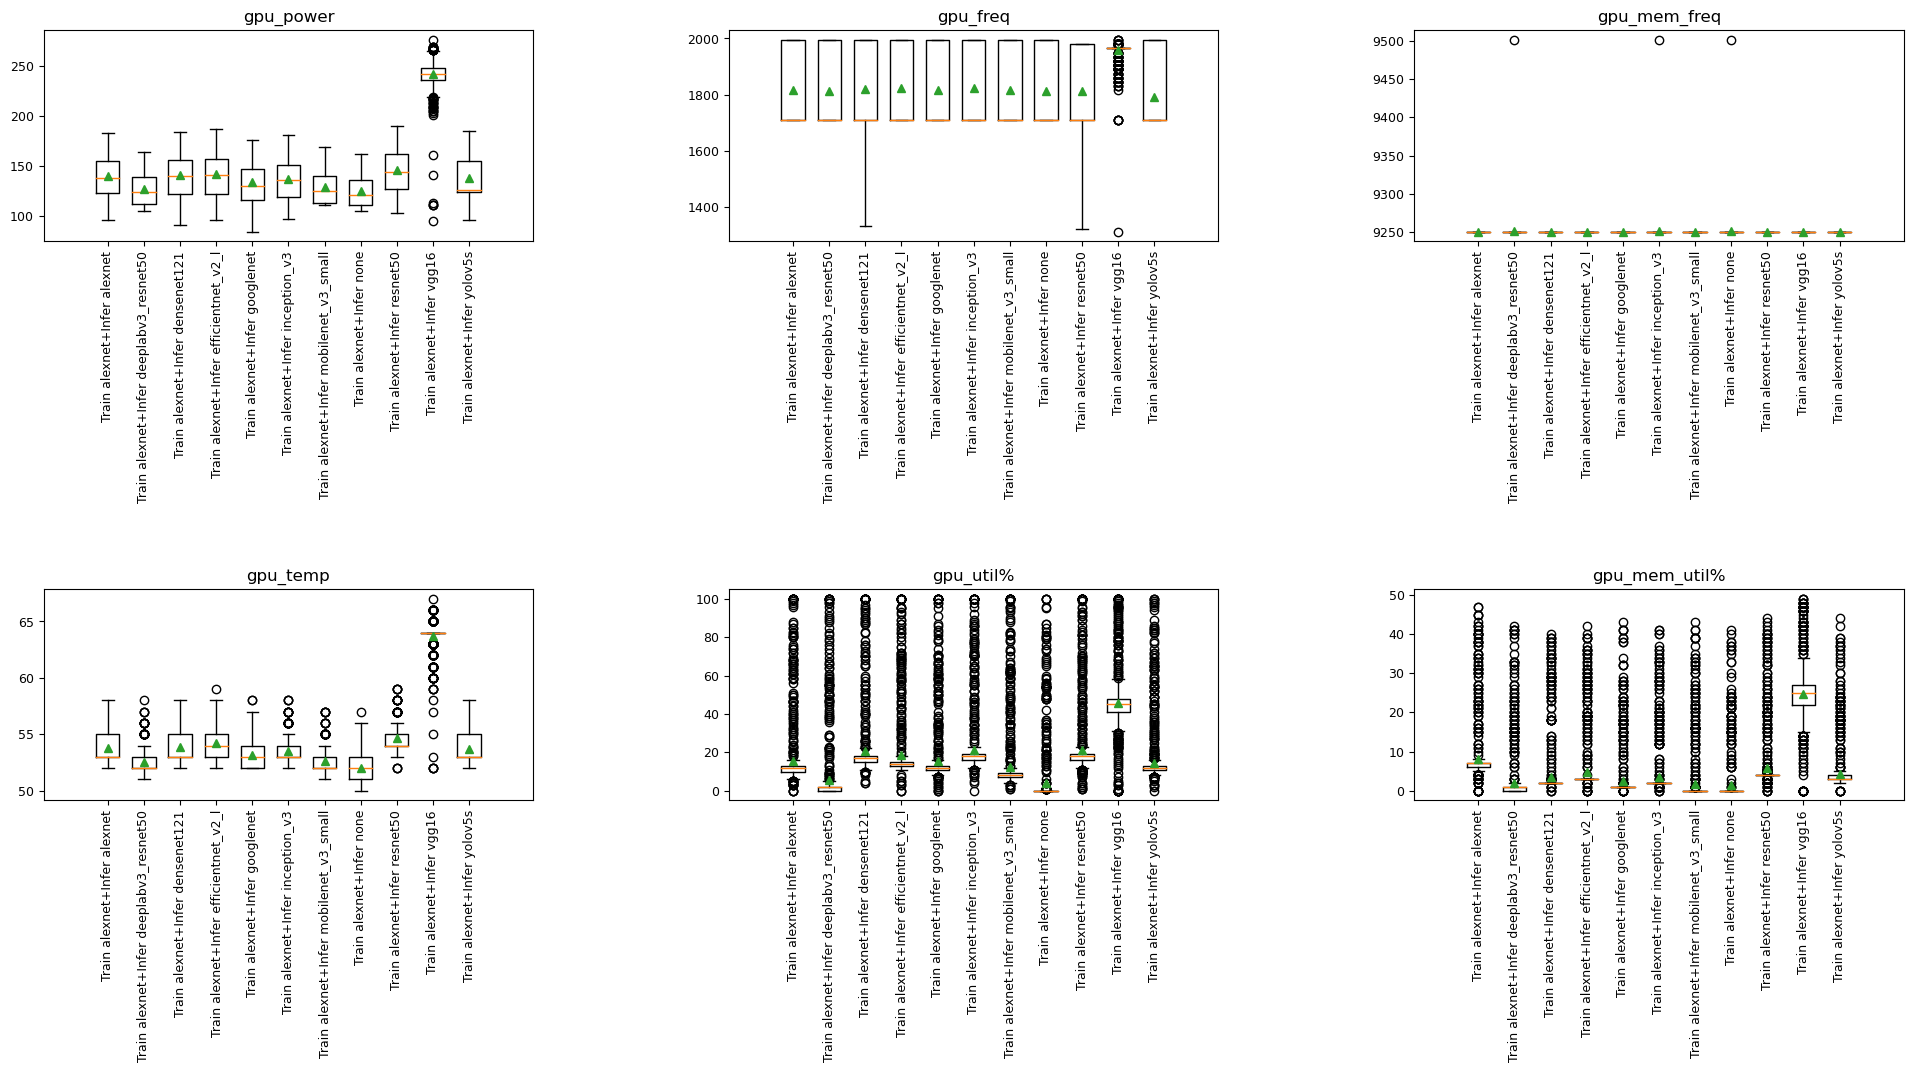

In [3]:
###  4. boxplot compare MANY files(the same training model+ various inference model) in one folder

# Plotting
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os        
import re
from utils import str2dict

root = '/home/royliu/Documents/temp/result_training/alexnet'

# str2dict(file_name):  # file name with .csv 
'''
e.g. input: 'Train arch_vgg16 workers_1 epochs_5 batch_size_64 image_size_224 device_cuda + Infer arch_alexnet workers_1 batch_size_1 image_size_224 device_cuda_20230211082435.csv'
output:
{'arch': 'vgg16', 'workers': '1', 'epochs': '5', 'batch_size': '64', 'image_size': '224', 'device': 'cuda'} {'arch': 'alexnet', 'workers': '1', 'batch_size': '1', 'image_size': '224', 'device': 'cuda'}

'''

file_name_list = []
task_name_list = []


# generate the file name list
for file_name in os.listdir(root):
    file_name_list.append(file_name)
#     file_name =  re.findall(r'(Train.+).csv',file_name)[0]  # extract filename start from "Train"
    t, i  = str2dict(file_name)
    task_names = 'Train '+t['arch']+'+'+'Infer '+i['arch']
    task_name_list.append(task_names)
task_name_list.sort()
file_name_list.sort()
# print(task_name_list,file_name_list)

plot_interval = 2/len(file_name_list)
col_slt = ['gpu_power','gpu_freq','gpu_mem_freq','gpu_temp','gpu_util%','gpu_mem_util%']
y_lim = {'gpu_power':(50,350), 'gpu_mem_freq':(7000,9600), 'gpu_freq':(1500,2150), 'gpu_temp':(45,65), \
         'gpu_util%':(0,100), 'gpu_mem_util%':(0,100)}

plot=plt.figure(figsize=(24, 10))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.4,hspace= len(file_name_list)*.15)

for j, col in enumerate(col_slt):
    plt.subplot(2,3,j+1) # e.g 
    for i in range(len(file_name_list)):
        data_slt = pd.read_csv(os.path.join(root,file_name_list[i]))
        y= data_slt[col].tolist()
        item = col + ': '+ task_name_list[i]        
        plt.boxplot(y, widths= plot_interval, positions = [i*(plot_interval+0.1)], labels = [task_name_list[i]],showmeans=True)
        plt.xticks(fontsize= 9, rotation = 90)  #set label size
        plt.yticks(fontsize= 9)  #set label size
        median, mean = np.median(y), np.mean(y)
#         plt.text(i*(plot_interval+0.1)+0.05,median*1, '%0.1f'%median, color= 'brown')
        plt.title(col, fontsize= 12)
#         plt.ylim(y_lim[col])

        f = file_name_list[0]
        train_model_name =  re.findall(r'Train (.+)\+.',f)[0]
plot.savefig(os.path.join(root,'../',(train_model_name+'.png')))


['Train vgg16+Infer none', 'Train vgg16+Infer yolov5s'] ['Train vgg16+Infer none.csv', 'Train vgg16+Infer yolov5s.csv']


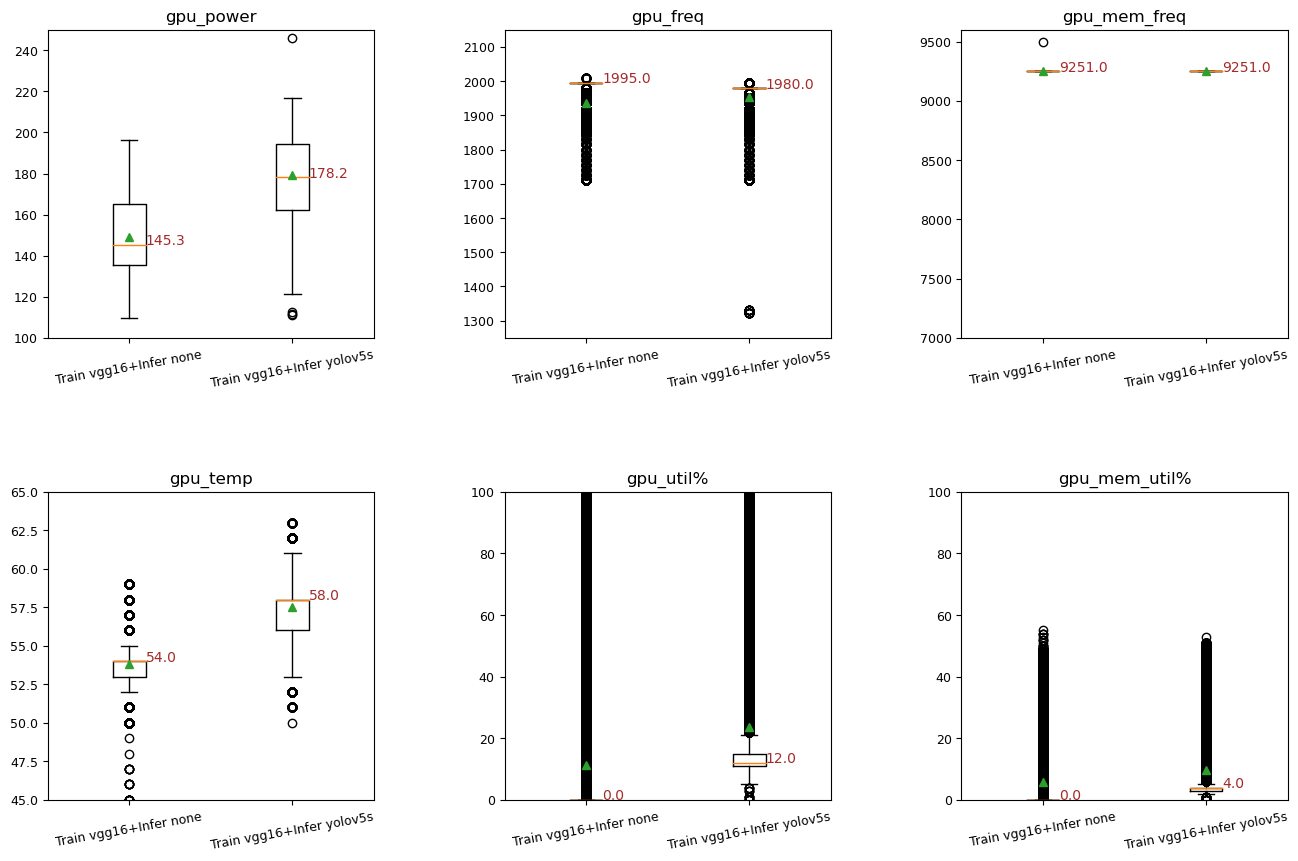

In [5]:
###  3. boxplot compare 2 files in one folder, make sure there are only 2 comparable files in one folder

# Plotting
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os        
import re


root = '/home/royliu/Documents/temp/result_training/vgg'

def filename2config(file_name):
    '''
    'Train arch_vgg16 workers_1 epochs_3 batch_size_32 image_size_224 device_cuda + Infer arch_resnet50 workers_1 epochs_3 batch_size_1 image_size_224 device_cuda'
    to
    'Train: arch_vgg16, workers_1, epochs_3, batch_size_32, image_size_224, device_cuda \r
    'Infer, arch_resnet50, workers_1, epochs_3, batch_size_1, image_size_224, device_cuda'
    '''
    tasks = file_name.split('+')  # saperate to two string of "Train" and "Infer"
    task_names = ''

    for i, task in enumerate(tasks):

        config_list = []  # task: string of train/infer, config[i]: list of batch_size, arch , etc
        config_list = task.strip().split(' ')
        config_str = config_list[0] + ' '  # add 'Train:', or 'infer'
        for i in range(1, len(config_list)):  # skip first element string of "Train"
            config_str += config_list[i] + ', '
        config_str = config_str[:-2]
        task_names = task_names+ config_str +'+'
    return task_names[:-1]

file_name_list = []
task_name_list = []

# generate the file name list
for file_name in os.listdir(root):
    file_name_list.append(file_name)
    file_name =  re.findall(r'(Train.+).csv',file_name)[0]  # extract filename start from "Train"
    task_names = filename2config(file_name)
    task_name_list.append(task_names)
task_name_list.sort()
file_name_list.sort()
print(task_name_list,file_name_list)

col_slt = ['gpu_power','gpu_freq','gpu_mem_freq','gpu_temp','gpu_util%','gpu_mem_util%']
y_lim = {'gpu_power':(100,250), 'gpu_mem_freq':(7000,9600), 'gpu_freq':(1250,2150), 'gpu_temp':(45,65), \
         'gpu_util%':(0,100), 'gpu_mem_util%':(0,100)}

plot=plt.figure(figsize=(16, 10))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.4,hspace=0.5)

for j, col in enumerate(col_slt):
    plt.subplot(2,3,j+1) # e.g 
    for i in range(2):
        data_slt = pd.read_csv(os.path.join(root,file_name_list[i]))
        y= data_slt[col].tolist()
        item = col + ': '+ task_name_list[i]        
        plt.boxplot(y, widths= 0.2, positions = [i*1], labels = [task_name_list[i]],showmeans=True)
        plt.xticks(fontsize= 9, rotation = 10)  #set label size
        plt.yticks(fontsize= 9)  #set label size
        median, mean = np.median(y), np.mean(y)
        plt.text(i*1+0.1,median*1, '%0.1f'%median, color= 'brown')
#         plt.text(i*.8+.1,mean*1.08, 'mean: '+'%0.1f'%mean, color ='green')
        plt.title(col, fontsize= 12)
        plt.ylim(y_lim[col])

        f = file_name_list[0]
        train_model_name =  re.findall(r'Train (.+)\+.',f)[0]
# plot.savefig(os.path.join(root,'../',(train_model_name+'.png')))




In [1]:
###  2. plot compare 2 files in one folder, make sure there are only 2 comparable files in one folder

# Plotting
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os


root = '/home/royliu/Documents/temp/result_training/compare1'
def filename2config(file_name):
    '''
    'Train arch_vgg16 workers_1 epochs_3 batch_size_32 image_size_224 device_cuda + Infer arch_resnet50 workers_1 epochs_3 batch_size_1 image_size_224 device_cuda'
    to
    'Train: arch_vgg16, workers_1, epochs_3, batch_size_32, image_size_224, device_cuda \r
    'Infer, arch_resnet50, workers_1, epochs_3, batch_size_1, image_size_224, device_cuda'
    '''
    tasks = file_name.split('+')  # saperate to two string of "Train" and "Infer"
    task_names = ''

    for i, task in enumerate(tasks):

        config_list = []  # task: string of train/infer, config[i]: list of batch_size, arch , etc
        config_list = task.strip().split(' ')
        config_str = config_list[0] + ' '  # add 'Train:', or 'infer'
        for i in range(1, len(config_list)):  # skip first element string of "Train"
            config_str += config_list[i] + ', '
        config_str = config_str[:-2]
        task_names = task_names+ config_str +'+'
    return task_names[:-1]

file_name_list = []
task_name_list = []
for file_name in os.listdir(root):
    file_name_list.append(file_name)

#     data = pd.read_csv(os.path.join(folder,file_name))
    print(re.findall(r'(Train.+).csv',file_name))
    file_name =  re.findall(r'(Train.+).csv',file_name)[0]  # extract filename start from "Train"
    task_names = filename2config(file_name)
    task_name_list.append(task_names)
    
file_name_list
task_name_list
col_slt = ['gpu_power','gpu_freq','gpu_temp','gpu_util%','gpu_mem_util%']
y_lim = {'gpu_power':(100,250), 'gpu_freq':(1250,2050), 'gpu_temp':(45,65), \
         'gpu_util%':(0,100), 'gpu_mem_util%':(0,100)}


for col in col_slt:
    plot=plt.figure(figsize=(20, 15))
    for i in range(2):
        data_slt = pd.read_csv(os.path.join(root,file_name_list[i]))
        x= data_slt['time'].tolist()    
        y= data_slt[col].tolist()
#         x= x[:20000]
#         y= y[:20000]
        item = col + ': '+ task_name_list[i]
        plt.plot(x,y, label = item)
        plt.legend(loc=1, fontsize = 14)
        plt.title(col, fontsize= 18)
        plt.xlabel('Time elapse (sec)', fontsize= 14)
        plt.ylim(y_lim[col])
    plot.savefig(os.path.join(root,('vgg16_'+col+'.png')))




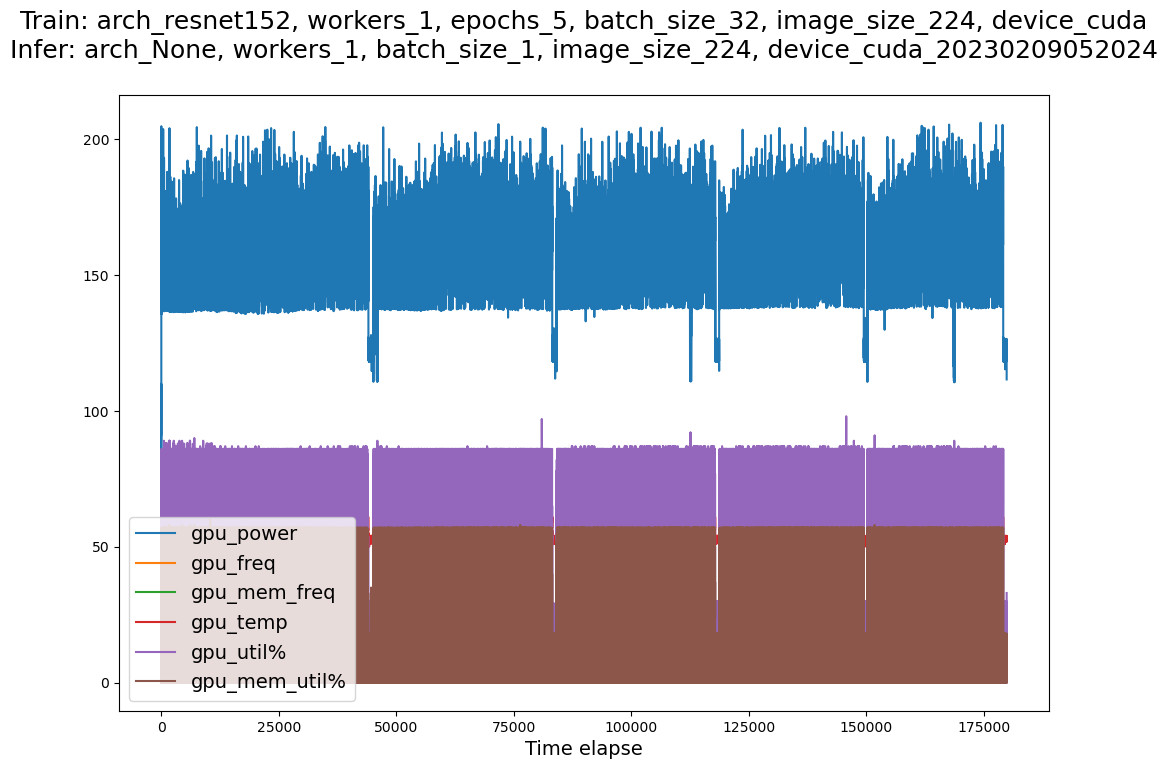

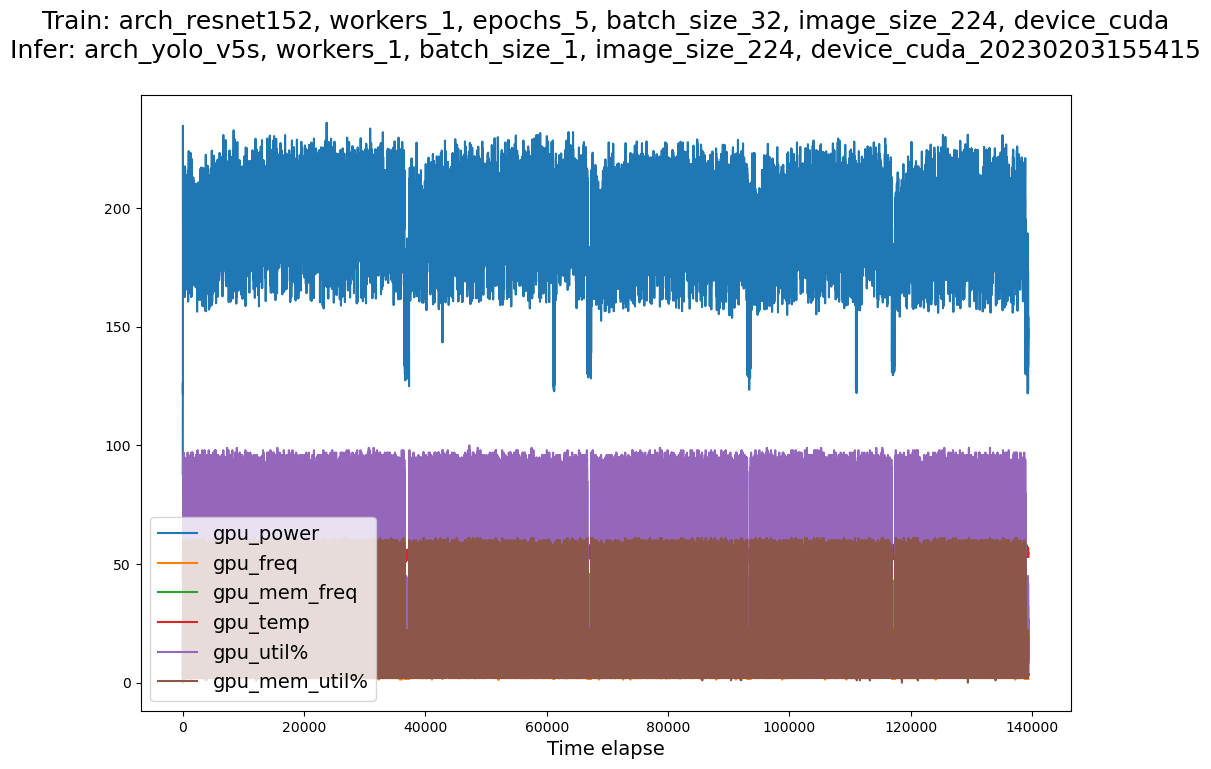

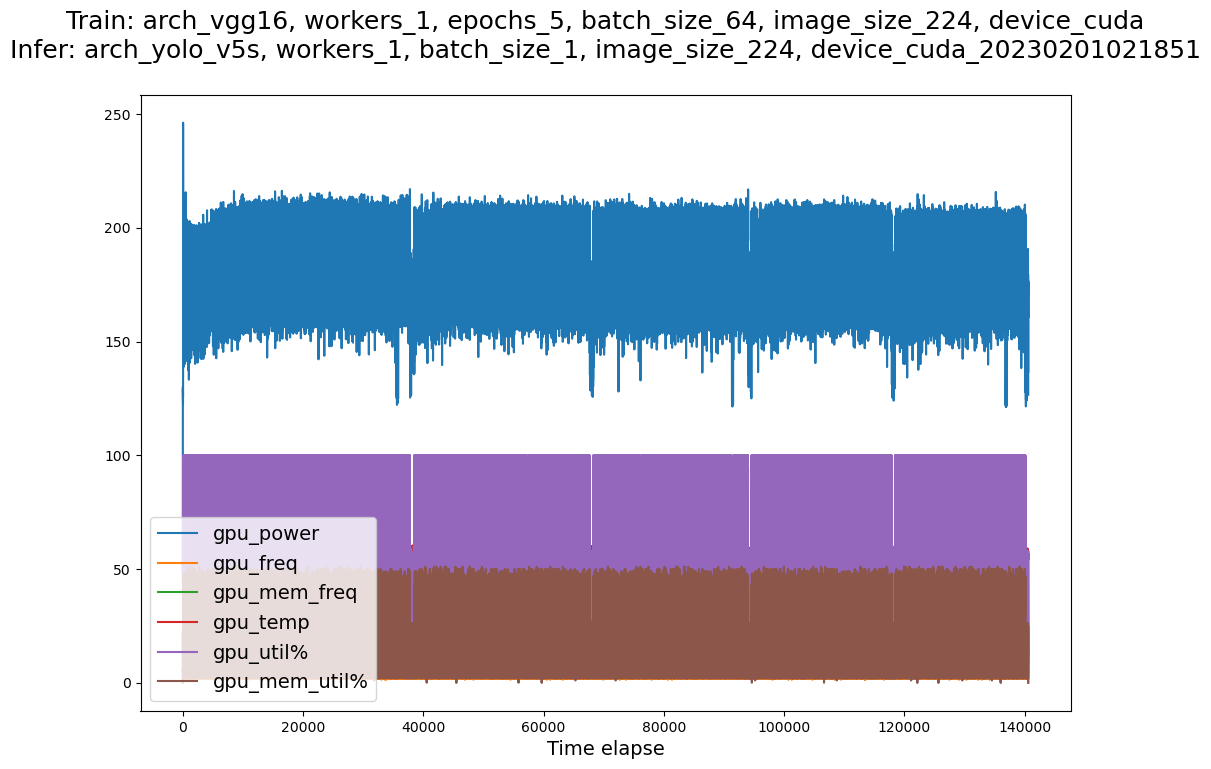

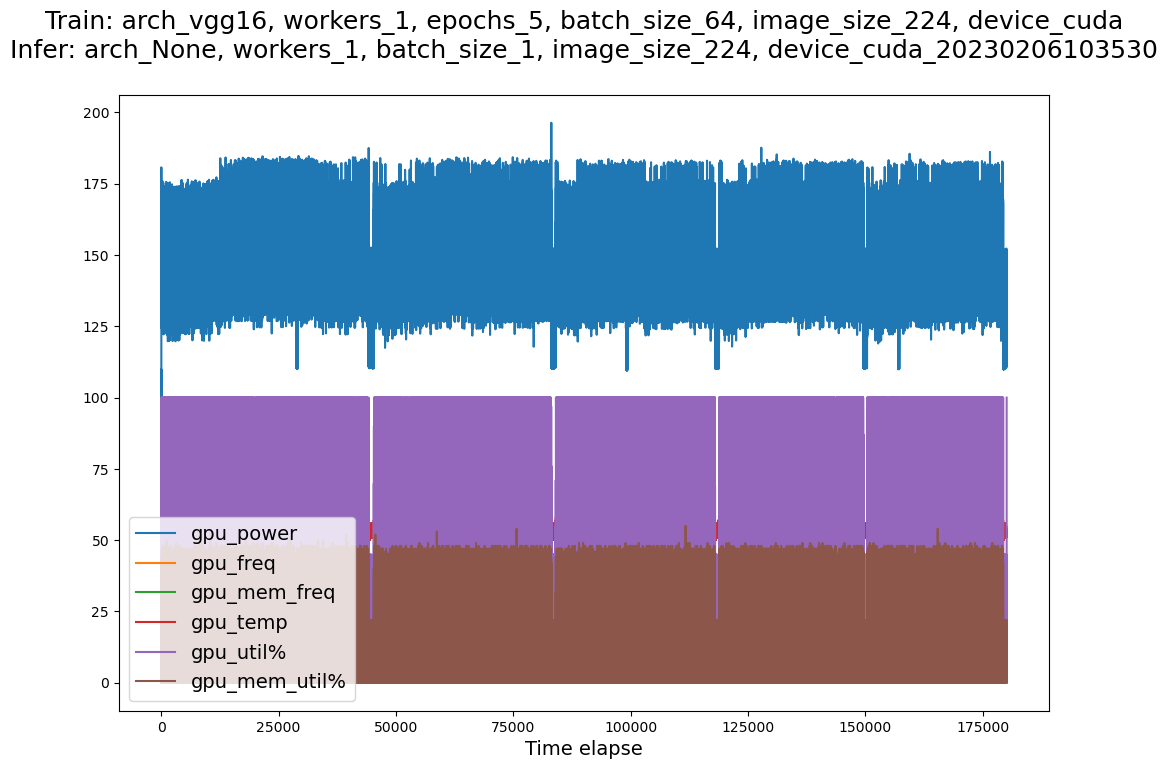

In [2]:
# 1. Plotting all
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

folder = '2022-12-22'
folder = os.path.join('../result/log',folder)
folder = '/home/royliu/Documents/temp/result_training'
def filename2config(file_name):
    '''
    'Train arch_vgg16 workers_1 epochs_3 batch_size_32 image_size_224 device_cuda + Infer arch_resnet50 workers_1 epochs_3 batch_size_1 image_size_224 device_cuda'
    to
    'Train: arch_vgg16, workers_1, epochs_3, batch_size_32, image_size_224, device_cuda \r
    'Infer, arch_resnet50, workers_1, epochs_3, batch_size_1, image_size_224, device_cuda'
    '''
    tasks = file_name.split('+')  # saperate to two string of "Train" and "Infer"
    task_names = ''

    for i, task in enumerate(tasks):

        config_list = []  # task: string of train/infer, config[i]: list of batch_size, arch , etc
        config_list = task.strip().split(' ')
        config_str = config_list[0] + ': '  # add 'Train:', or 'infer'
        for i in range(1, len(config_list)):  # skip first element string of "Train"
            config_str += config_list[i] + ', '
        config_str = config_str[:-2]
        task_names = task_names+ config_str+'\n'
    return task_names
        
for file_name in os.listdir(folder):
    data = pd.read_csv(os.path.join(folder,file_name))
    file_name =  re.findall(r'(Train.+).csv',file_name)[0]  # extract filename start from "Train"
    task_names = filename2config(file_name)
        
   
    col_sel = ['gpu_power','gpu_freq','gpu_mem_freq','gpu_temp','gpu_util%','gpu_mem_util%']
    data_sel = data[col_sel]

    plot=plt.figure(figsize=(12, 8))
    y= data_sel.index
    for item in col_sel:
        x= (data_sel[item]).tolist()
        if re.findall(r'(gp.+?)\_freq', item):  # gpu frequency
            for i in range(len(x)):x[i] = float(x[i])/1e3
        elif re.findall(r'(cp.+?)\_freq',item):  #if is cpu frequency
            for i in range(len(x)): x[i] = float(x[i])/1e6
        else:
            for i in range(len(x)): x[i] = float(x[i])
        plt.plot(y,x, label = item)
    plt.legend(loc=3, fontsize = 14)
    plt.title(task_names, fontsize= 18)
    plt.xlabel('Time elapse', fontsize= 14)
    plt.show()

    plot.savefig('../result/plot/'+file_name+'.jpg')



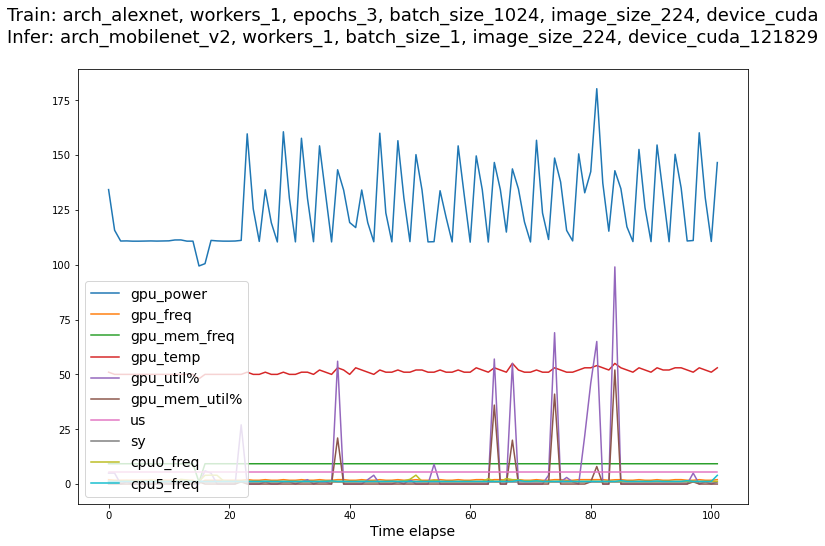

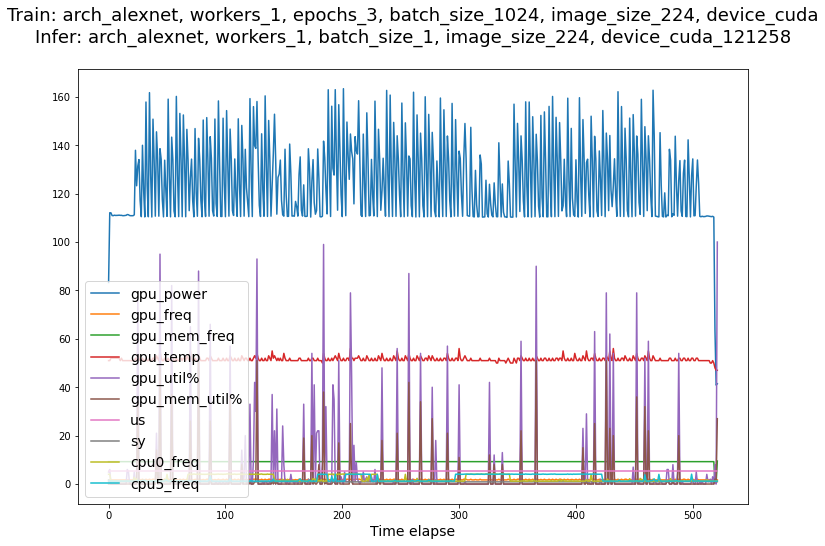

In [48]:
# Plotting
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

folder = '2022-12-22'
folder = os.path.join('../result/log',folder)

def filename2config(file_name):
    '''
    'Train arch_vgg16 workers_1 epochs_3 batch_size_32 image_size_224 device_cuda + Infer arch_resnet50 workers_1 epochs_3 batch_size_1 image_size_224 device_cuda'
    to
    'Train: arch_vgg16, workers_1, epochs_3, batch_size_32, image_size_224, device_cuda \r
    'Infer, arch_resnet50, workers_1, epochs_3, batch_size_1, image_size_224, device_cuda'
    '''
    tasks = file_name.split('+')  # saperate to two string of "Train" and "Infer"
    task_names = ''

    for i, task in enumerate(tasks):

        config_list = []  # task: string of train/infer, config[i]: list of batch_size, arch , etc
        config_list = task.strip().split(' ')
        config_str = config_list[0] + ': '  # add 'Train:', or 'infer'
        for i in range(1, len(config_list)):  # skip first element string of "Train"
            config_str += config_list[i] + ', '
        config_str = config_str[:-2]
        task_names = task_names+ config_str+'\n'
    return task_names
        
for file_name in os.listdir(folder):
    data = pd.read_csv(os.path.join(folder,file_name))
    file_name =  re.findall(r'(Train.+).csv',file_name)[0]  # extract filename start from "Train"
    task_names = filename2config(file_name)
        
   
    col_sel = ['gpu_power','gpu_freq','gpu_mem_freq','gpu_temp','gpu_util%','gpu_mem_util%', 'us','sy','cpu0_freq','cpu5_freq']
    data_sel = data[col_sel]

    plot=plt.figure(figsize=(12, 8))
    y= data_sel.index
    for item in col_sel:
        x= (data_sel[item]).tolist()
        if re.findall(r'(gp.+?)\_freq', item):  # gpu frequency
            for i in range(len(x)):x[i] = float(x[i])/1e3
        elif re.findall(r'(cp.+?)\_freq',item):  #if is cpu frequency
            for i in range(len(x)): x[i] = float(x[i])/1e6
        else:
            for i in range(len(x)): x[i] = float(x[i])
        plt.plot(y,x, label = item)
    plt.legend(loc=3, fontsize = 14)
    plt.title(task_names, fontsize= 18)
    plt.xlabel('Time elapse', fontsize= 14)
    plt.show()

    plot.savefig('../result/plot/'+file_name+'.jpg')



# backup

In [26]:
folder = '2022-12-08'
folder = os.path.join('../result/log',folder)
for file_name in os.listdir(folder):
    model_name =  re.findall(r'(.+).csv',file_name)
    print (model_name)

['004328_archvgg16_workers1_epochs3_batch_size16']


In [3]:
import os
import json
import pandas as pd

folder = '2022-12-08'
folder = os.path.join('../result/log',folder)
file_name = '105057_archvgg16_workers1_epochs3_batch_size16_image_size224.json'
data = pd.read_json(os.path.join(folder,file_name))
data

,time_stamp,gpu_power,gpu_freq,gpu_mem_freq,gpu_temp,gpu_util%,gpu_mem_util%,gpu_name,timestamp,us,...,wa,hi,si,st,cpu0_freq,cpu1_freq,cpu2_freq,cpu3_freq,cpu4_freq,cpu5_freq
0,1.670515e+09,8.00,265,405,50,1,3,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:39.133843200,14.6,...,1,0,0,0,3333249,3333249,3333347,3333239,3333383,3333226
1,1.670515e+09,13.04,265,405,50,0,3,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:39.898204160,20.6,...,1,0,0,0,3333247,3333245,3333282,3333277,3333315,3333226
2,1.670515e+09,9.65,265,405,50,0,3,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:40.681239296,18.4,...,0,0,0,0,3402614,3382265,3424323,3394703,3460744,3449651
3,1.670515e+09,8.19,265,405,50,0,3,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:41.453420032,18.4,...,0,0,0,0,3510612,3558960,3463147,3512543,3536994,3587372
4,1.670515e+09,8.29,265,405,50,0,3,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:42.230558976,16.7,...,0,0,0,0,3521713,3553174,3525860,3520857,3545327,3587526
5,1.670515e+09,31.40,1556,3802,51,7,1,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:43.002341632,14.3,...,0,0,0,0,3338408,3304996,3419799,3329057,3305468,3376074
6,1.670515e+09,31.41,1556,3802,51,6,1,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:43.777405696,12.2,...,0,0,0,0,3321639,3333324,3333227,3324594,3332472,3332154
7,1.670515e+09,31.41,1556,3802,51,7,1,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:44.554600960,18.4,...,0,0,0,0,3333311,3333337,3333231,3321638,3333360,3332633
8,1.670515e+09,33.44,1721,3802,51,0,0,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:45.315313664,17.3,...,0,0,0,0,3333228,3333330,3333279,3333302,3333281,3333227
9,1.670515e+09,33.54,1721,3802,51,0,0,NVIDIA GeForce GTX 1060 6GB,2022-12-08 15:50:46.069488384,18.6,...,0,0,0,0,3398792,3341158,3375901,3387952,3435764,3405656
